# Using statistics in agile estimation #

In Scrum, and in general in any Agile process, starting with Extreme Programming, the development is split into fixed-length iterations or sprints. Before the beginning of each sprint, the team is doing sprints planning and allocates the work for the sprint based on the priority of user stories. The question is, how many stories the team can complete in one iteration? 

The unit of work started from "ideal hours" in Extreme Programming, which is different from the real hours. Ideal hours is the number of hours available to the team to actually do work. Moreover, the estimate was multiplied by the load factor, initially set to 3. 

This fairly complex models seemed ineffective and was replaced to story points. They are abstract measure of complexity of the user story, and the values are assigned based on the similar user stories, done in the past, and a ceremony called "planning poker". The number of story points the team can do within one iteration is called project velocity. It is measured based on the "Yesterday's weather" rule. 

The number of story points completed varies in the past iterations, so it is natural to use statistical methods to model the project velocity. The probability distribution that addresses this problem is [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution):

$$ p(k) = \frac {\lambda^k e^{-\lambda}}{k!} $$

where p(k) is the probability of completing k user stories, and $\lambda$ is the project velocity. We can infer the project velocity relatively easily in Python. Let's say after 5 iterations we have these numbers of story points completed:

In [2]:
import numpy as np
from scipy.stats import poisson

In [3]:
data=np.array([14, 12,  7, 14, 13])

To infer the parameter of the distribution, we just take an average:

In [4]:
velocity = data.mean()
velocity

12.0

So, our velocity is 12 story points per iteration. The median of the distribution is:

In [5]:
poisson(velocity).median()

12.0

This means, that there is only 50% chance we can complete all 12 story points in an iteration. Is this what the management is asking for? Probably not. They want a commitment, or at least, 95% confidence. We can also easily get that:

In [6]:
poisson(velocity).ppf(0.05)

7.0

This means, that we can report to the management, that with 95% confidence we can complete 7 story points within one iteration.

The project velocity may have a systematic error if the individual developers' velocity is drastically different. A good Agile project not only tracks the team velocity, but also developer velocity, and adjust the former based on the latter.

The project velocity may also depend on other factors. The developers are getting better in estimating the stories, the team is becoming faster, so it may not makes sense to use all historical data equally. We can perhaps use exponential moving average:

In [7]:
def exponential_moving_average(data, size, weight):
    considered = data[data.shape[0] - size:]
    exponents = np.arange(size, 0, -1)
    weights = weight ** exponents
    weights /= sum(weights)
    return (considered*weights).sum()

In [8]:
velocity = exponential_moving_average(data, 3, 0.5)
velocity

12.428571428571427

Here we see, that based on the last three iterations our project velocity is slightly higher, than the total velocity. 

In addition to moving average, we can try to fit data to [Poisson Regression Model](https://en.wikipedia.org/wiki/Poisson_regression), however, in that model the distribution parameter exponentially depends on the linear combination of parameters, so it is unstable for the long range.

$$ \lambda = e^{\theta x} $$

What happens in reality, that the velocity after fluctuating in the earlier stages of the projects tends to settle to a specific value in the later iterations, which, obviously, cannot be modeled with the exponential function. 

This approach have some difficulties. These difficulties, along with a better approach are described in [another notebook](agile_estimation_2.ipynb)

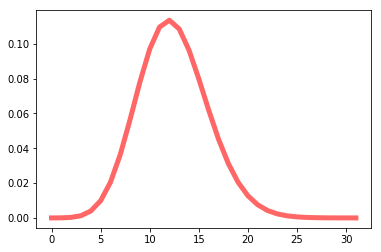

In [13]:
#Let's plot the distribution
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
x = np.arange(0, 32)
frozen = poisson(velocity)
ax.plot(x, frozen.pmf(x), 'r-', lw=5, alpha=0.6, label='lognorm pdf');